##### Audio Classification Using Edge Impulse
This example uses audio input from fast analog input IN2 and uses local Edge Impulse Classification to classigy 5 seconds of audio.

This is based on the Edge Immpulse example:
https://github.com/edgeimpulse/linux-sdk-python/blob/master/examples/audio/classify.py
The following are required to use the edge_impulse_linux:  
<code>
apt install libatlas-base-dev libportaudio0 libportaudio2 libportaudiocpp0 portaudio19-dev python3-opencv
pip3 install PyAudio
pip3 install edge_impulse_linux</code>

In [1]:
from redpitaya.overlay.mercury import mercury as overlay
import IPython.display as ipd
import matplotlib.pyplot as plt

#Audio processing requirements
import os
import sys, getopt
import signal
import numpy as np
from scipy.io import wavfile

#Edge Impulse requirements
import json
import time, hmac, hashlib
import requests
import re, socket
import math
from edge_impulse_linux.runner import ImpulseRunner

fpga = overlay()

Time taken to load BIN is 238.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully
Load overlay [OK].


In [2]:
in2 = fpga.osc(1, 1.0)
# data rate decimation 
in2.decimation = 41667 #125 Msps / 41667 = 30 Ksps

# trigger timing [sample periods]
N = in2.buffer_size
in2.trigger_pre  = 0
in2.trigger_post = N

# disable hardware trigger sources - the Jupyter notebook will trigger the start of audio recording
in2.trig_src = 0

In [36]:
def record_audio():
    # synchronization and trigger sources are the default,
    # which is the module itself
    in2.reset()
    in2.start()
    in2.trigger()
    print ('Recording started')
    # wait for data
    while (in2.status_run()): pass
    print ('Recording complete')
    data = in2.data(N)
    return data[1:] #Remove first sample as it maybe zero

audio_data_returned = record_audio()

Recording started
Recording complete


In [14]:
def display_audio(audio_data,sr = 3000): #default sample rate 3 Ksps
    return ipd.Audio(audio_data, rate=sr) # load a NumPy array

python_display_audio = display_audio(audio_data_returned, sr = 3000)
python_display_audio

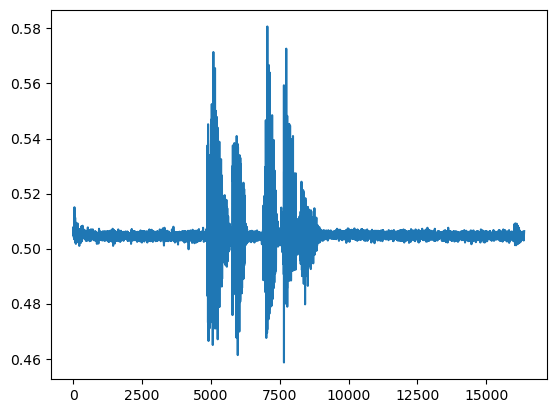

In [37]:
def plot_audio(audio_data):
    # show the part of the buffer requested by pre/post trigger timing - in this example the whole buffer.
    plt.plot(audio_data_returned)
    plt.show()

plot_audio(audio_data_returned)

In [28]:
def save_audio(audio_data, file, sr = 3000): #default sample rate 3 Ksps
    wavfile.write("float_wave_test_raw.wav", sr, audio_data)

# Add the files you want to upload to Edge Impulse
files = ['float_wave_test_raw.wav']
file = files[0] #save the first one
save_audio(audio_data_returned, file, sr = 3000)

In [8]:
runner = None
model_file_name = 'modelfile.eim'
audio_file_name = 'float_wave_test_raw.wav'

dir_path = os.path.dirname(os.path.realpath(model_file_name))
modelfile = os.path.join(dir_path, model_file_name)
audio_file = os.path.join(dir_path, audio_file_name)

In [9]:
samplerate, generator = wavfile.read(audio_file)

features = np.array([], dtype=np.int16)
runner = ImpulseRunner(modelfile)

model_info = runner.init()
labels = model_info['model_parameters']['labels']
window_size = model_info['model_parameters']['input_features_count']
sampling_rate = model_info['model_parameters']['frequency']
print('Loaded runner for "' + model_info['project']['owner'] + ' / ' + model_info['project']['name'] + '"')
print('labels: ', labels)
print('window_size: ', window_size)
print('sampling_rate: ', sampling_rate)

Loaded runner for "John Bracegirdle / Sound Test"
labels:  ['background-noise', 'edge-impulse', 'red-pitaya']
window_size:  15000
sampling_rate:  3000


In [10]:
samplerate, generator = wavfile.read(audio_file)
features = np.concatenate((features, generator), axis=0)
res = runner.classify(features[:window_size].tolist())
res

{'result': {'classification': {'background-noise': 0.9999970197677612,
   'edge-impulse': 7.159869142014941e-07,
   'red-pitaya': 2.291571036039386e-06}},
 'timing': {'anomaly': 0,
  'classification': 4,
  'dsp': 24,
  'json': 16,
  'stdin': 37}}

In [34]:
print('Result (%d ms.) ' % (res['timing']['dsp'] + res['timing']['classification']), end='')
for label in labels:
    score = res['result']['classification'][label]
    print('%s: %.2f\t' % (label, score), end='')
    print('', flush=True)

Result (27 ms.) background-noise: 1.00	
edge-impulse: 0.00	
red-pitaya: 0.00	


In [12]:
#Show the classification key that has the highest confidence index
best_label = max(res['result']['classification'], key=lambda key: res['result']['classification'][key])
confidence = res['result']['classification'][best_label]
print(best_label,"{:.2%}".format(confidence))

background-noise 100.00%


Recording started
Recording complete


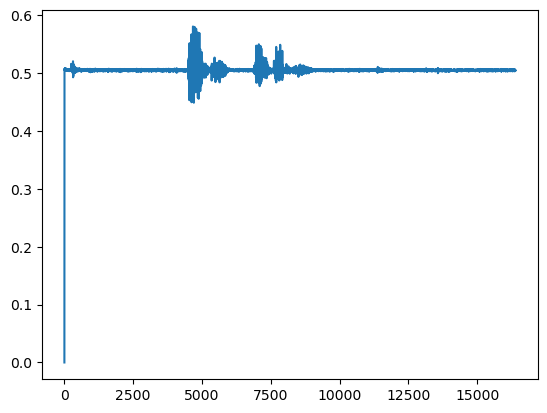

In [35]:
audio_data_returned = record_audio()
save_audio(audio_data_returned, file, sr = 3000)
plot_audio(audio_data_returned)

In [38]:
samplerate, generator = wavfile.read(audio_file)
features = np.concatenate((features, generator), axis=0)
res = runner.classify(features[:window_size].tolist())

#Show the classification key that has the highest confidence index
best_label = max(res['result']['classification'], key=lambda key: res['result']['classification'][key])
confidence = res['result']['classification'][best_label]
print(best_label,"{:.2%}".format(confidence))

background-noise 100.00%
